# Polygon extraction
To extract the relevant data from the underlying image of Europe.  
![Europe 1918](input/europe_1918.png)
## 1. Remove non-map data
Such as : 
- The year indicator
- The population count
- The author's logo


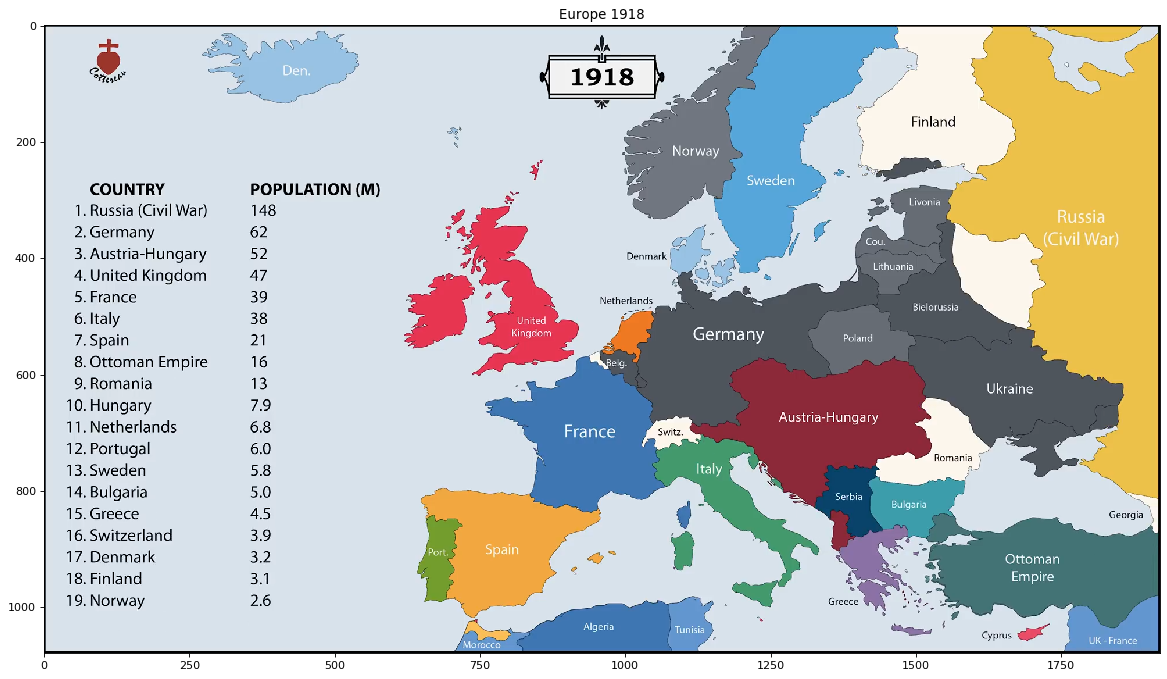

In [227]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import color
from shapely.geometry import box
from skimage import transform

def display_img(img, title="", big=False) : 
    if big : 
        fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.show()

europe = color.rgba2rgb(plt.imread('input/europe_1918.png'))
display_img(europe, 'Europe 1918', True)


## 2. Keep only the relevant colors

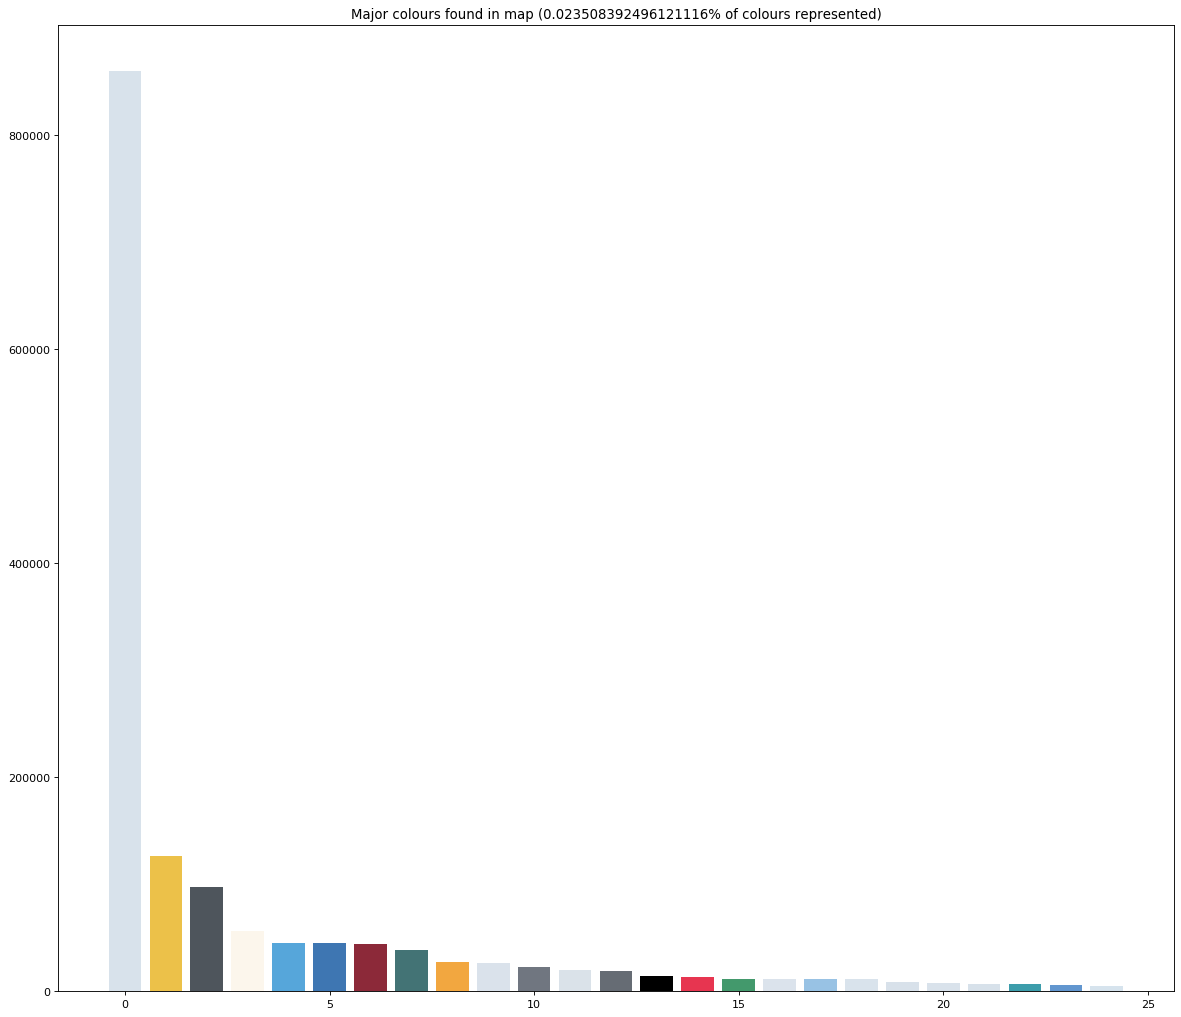

In [223]:
import pandas as pd
def extract_major_colors(img) :
    unique, counts = np.unique(img.reshape(int(img.size/3), 3), axis=0, return_counts=True)
    scores = list(zip(counts, unique))
    df = pd.DataFrame(scores, columns=['count', 'value']).sort_values(by=['count'], ascending=False)
    return df
def print_colors(extracted_colors):
    toplot = extracted_colors[:25]
    percentage = 100 * len(toplot)/len(extracted_colors)
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.bar(np.arange(len(toplot)) , toplot['count'].values , color=toplot['value'].values)
    plt.title('Major colours found in map ('+str(percentage)+'% of colours represented)')
    plt.show()
extracted =  extract_major_colors(europe)
print_colors(extracted)

As displayed above, the image contains way too many colours. If we plan to extract countries based on colours, we'll first have to regroup these colours to make sense.  
This cane be done with the following clustering algorithm

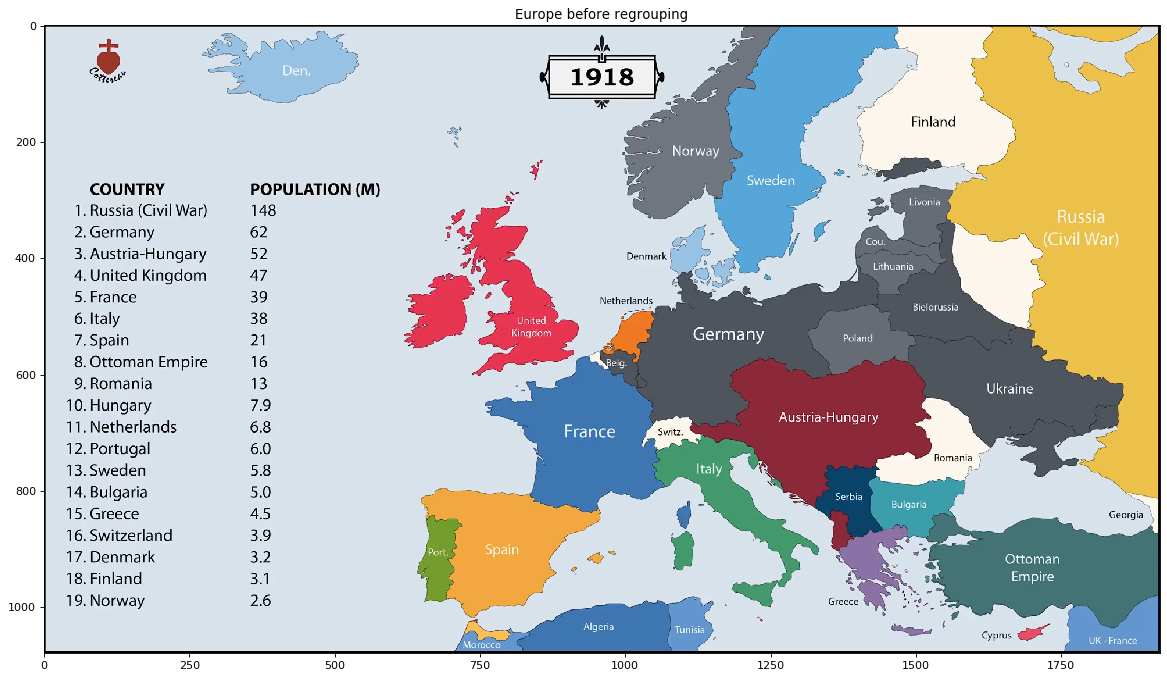

CPU times: user 9.59 s, sys: 35.6 ms, total: 9.62 s
Wall time: 8.55 s


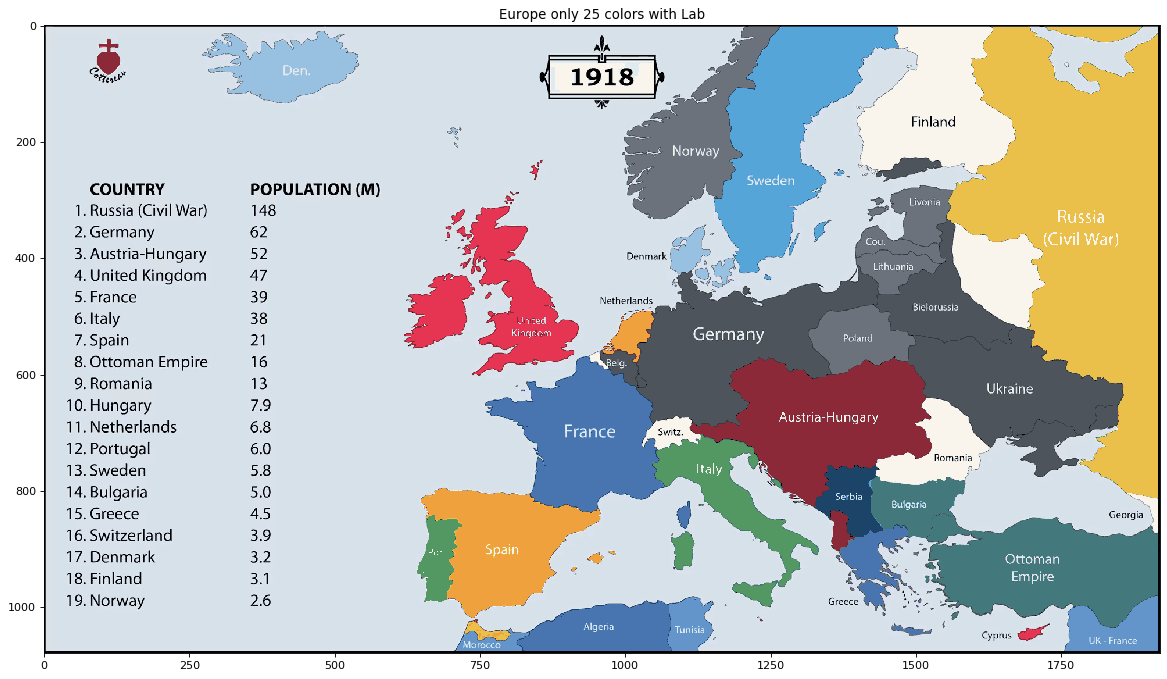

In [282]:
from sklearn.cluster import MiniBatchKMeans
def regroup_colors(image, nb_color) :
    (h, w) = image.shape[:2]
    data = image.copy()
    # Lab is a colour representation (l, a , b). 
    #It is made so that if (l, a , b) differs numerically, the perceived colour by humans will also differ
    data = color.rgb2lab(data)
    data = data.reshape((h*w, 3))
    clt = MiniBatchKMeans(n_clusters = nb_color, random_state = 0)
    labels = clt.fit_predict(data)
    res = clt.cluster_centers_[labels].reshape((h, w, 3))
    res = color.lab2rgb(res)
    return res
display_img(europe, "Europe before regrouping", True)
%time clustered_europe = regroup_colors(europe, 25)
display_img(clustered_europe, "Europe only 25 colors with Lab", True)

Now, the colour count has a meaning

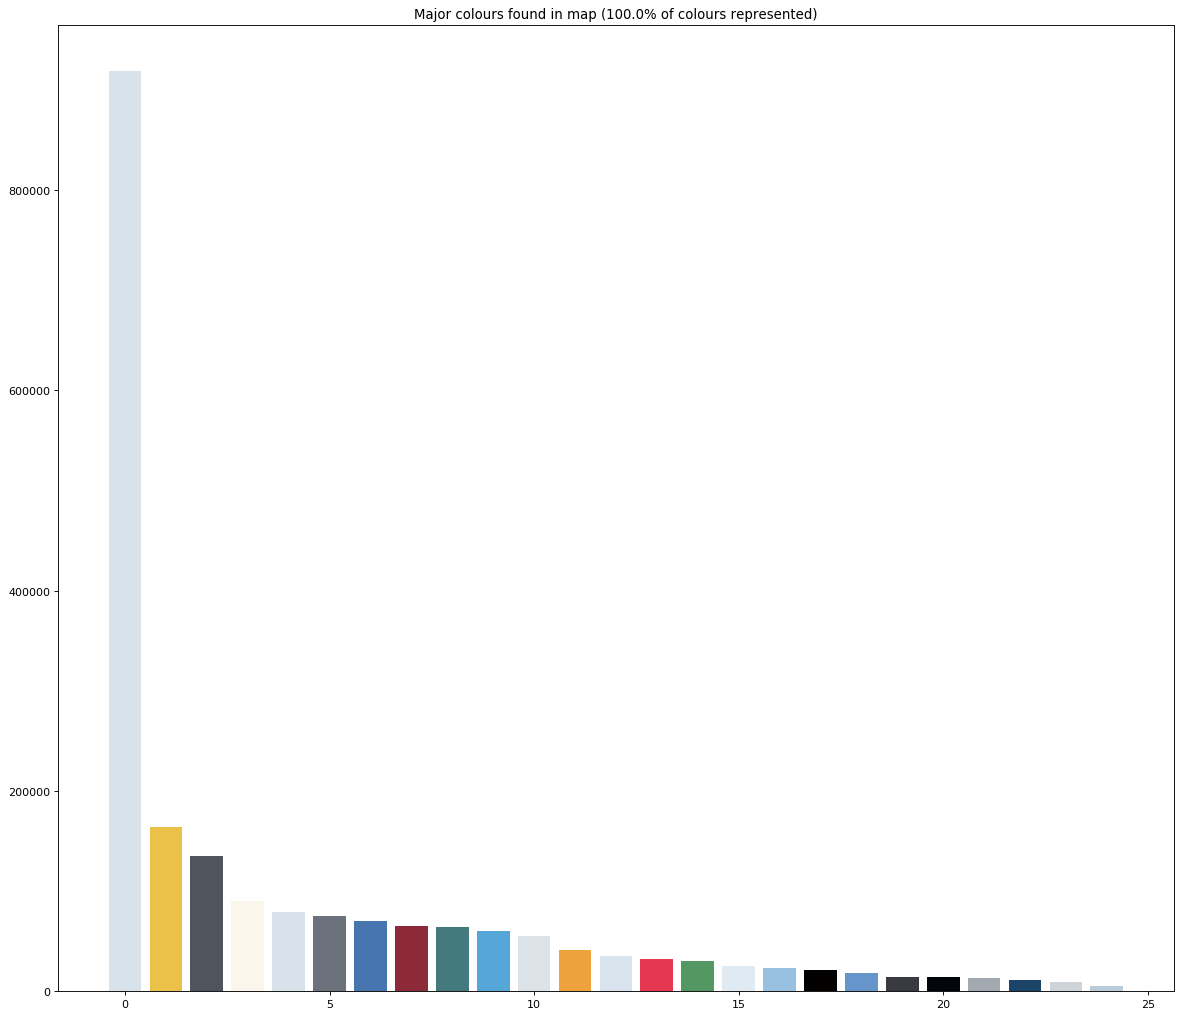

In [283]:
extracted_colors =  extract_major_colors(clustered_europe)
print_colors(extracted_colors)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


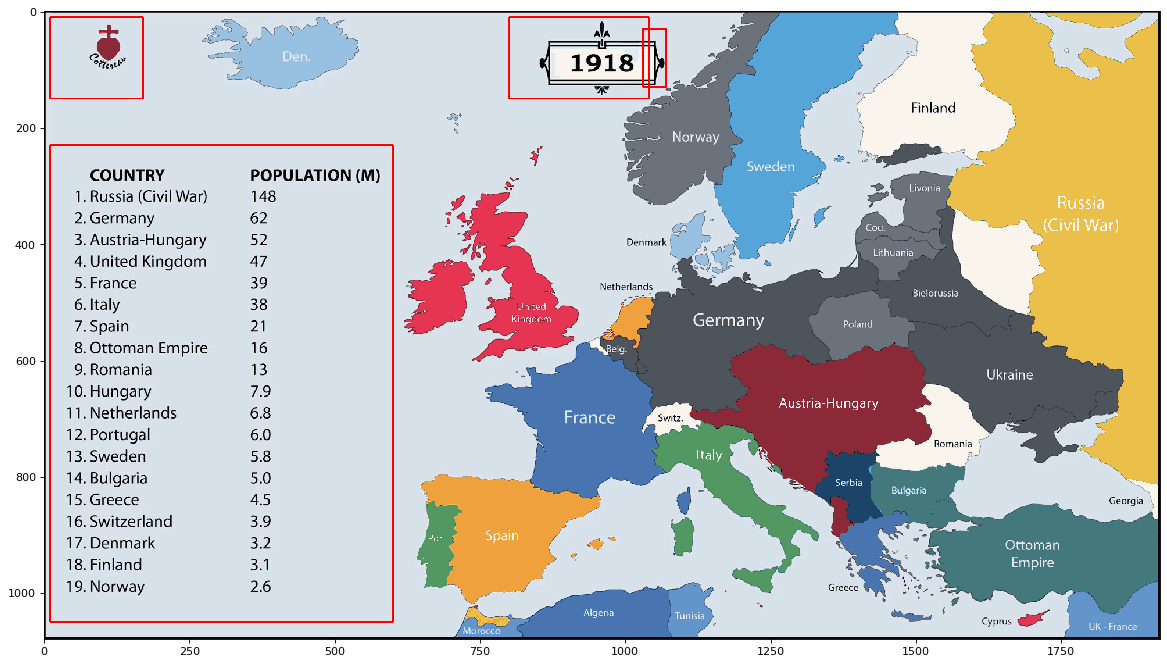

[0.84678877 0.88627342 0.92151525]
10 230 600 1050
10 10 170 150
800 10 1040 150
1030 30 1070 130


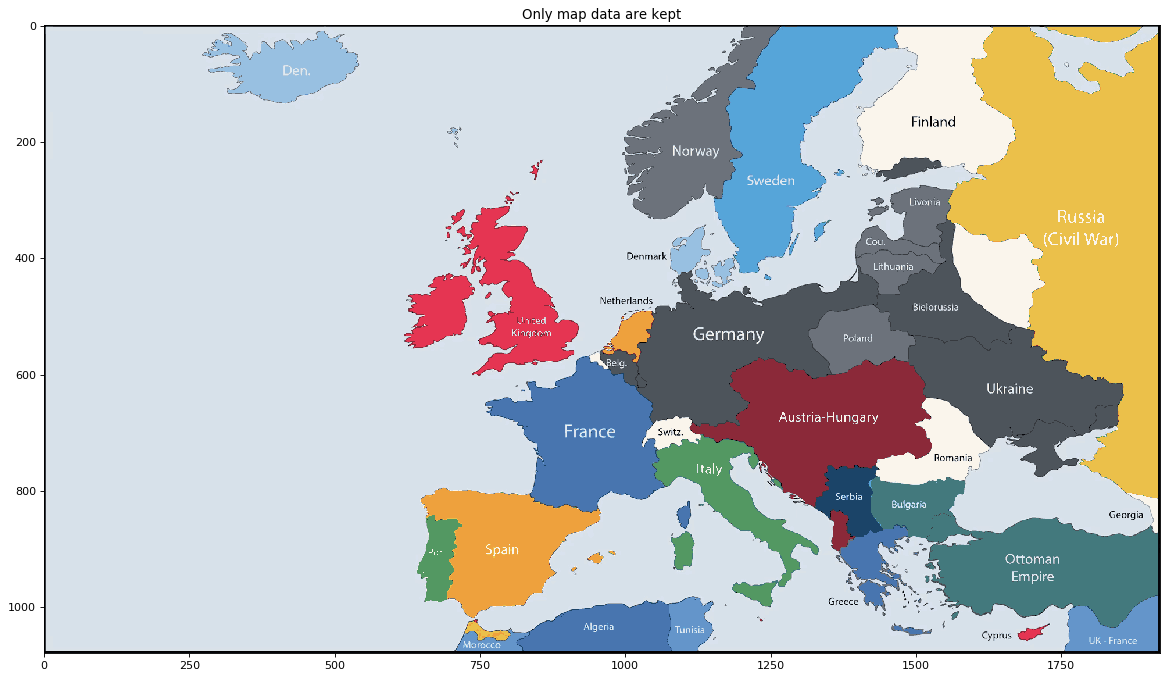

In [284]:
def disp_polygons(img, polygons) :
    todisp = img.copy()
    for polygon in polygons :
        [_, bottom_right, _, top_left, _] = [(int(x), int(y)) for (x, y) in polygon.exterior.coords]
        cv2.rectangle(todisp, top_left, bottom_right, (230, 0, 0), 2)
    display_img(todisp, '', True)
def fill_polygons(img, polygons, fill_color):
    res = img.copy()
    for polygon in polygons :
        [_, (xb, yb), _, (xa, ya), _] = [(int(x), int(y)) for (x, y) in polygon.exterior.coords]
        print(xa, ya, xb, yb)
        res[ya:yb, xa:xb] = fill_color
    return res

population_text_box = box(10, 230, 600, 1050)
logo_text_box = box(10, 10, 170, 150)
year_text_box_1 = box(800, 10, 1040, 150)
year_text_box_2 = box(1030, 30, 1070, 130)

to_remove = [population_text_box, logo_text_box, year_text_box_1, year_text_box_2]
disp_polygons(clustered_europe, to_remove)


sea_color = extracted_colors.iloc[0].value
print(sea_color)
europe_cleaned = fill_polygons(clustered_europe, to_remove, sea_color)
#europe_cleaned = transform.resize(europe_cleaned, (europe_cleaned.shape[0]/10, europe_cleaned.shape[1]/10))
display_img(europe_cleaned, 'Only map data are kept', True)

## Country extraction with a mask
Assuming colours exactly define the country, a mask can be applied to extract the country's borders


[0.88042387 0.75763051 0.32860646 0.96414069 0.88112217 0.445738
 0.43954898 0.25025505 0.43339906 0.59874735 0.88331913 0.66956946
 0.88384898 0.36578572 0.5250637  0.91181925 0.73165454 0.00430006
 0.5597237  0.22853693 0.022409   0.65954847 0.24385818 0.82713005
 0.78657851]
0.880423870251782


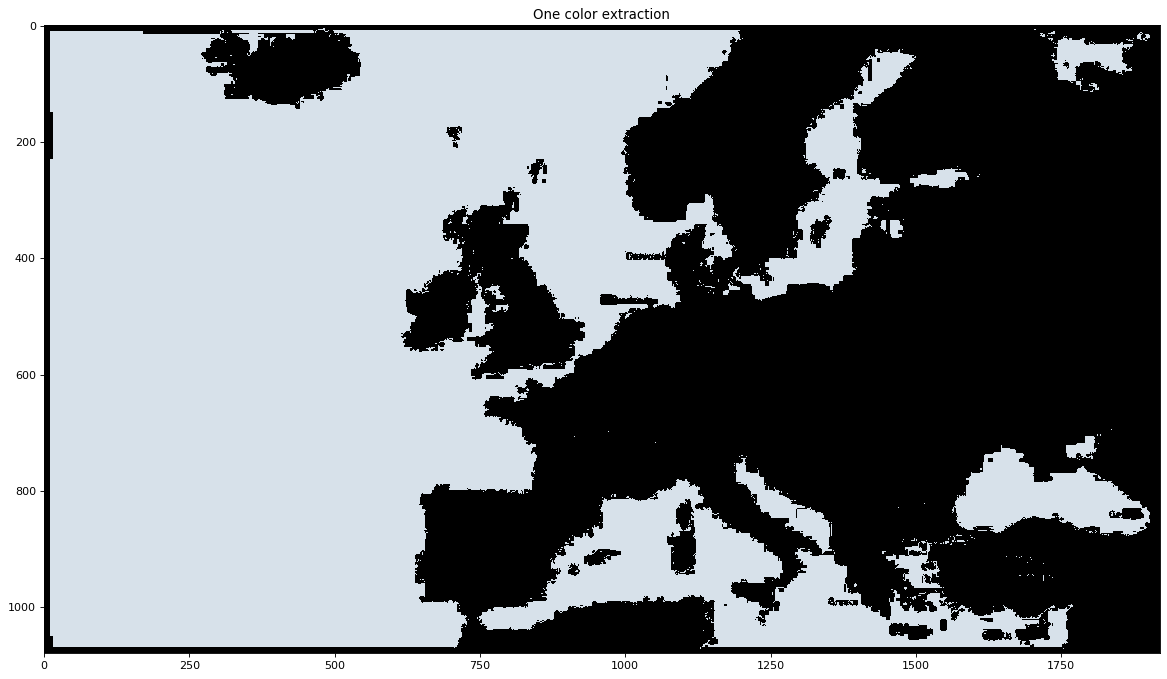

0.7576305062942461


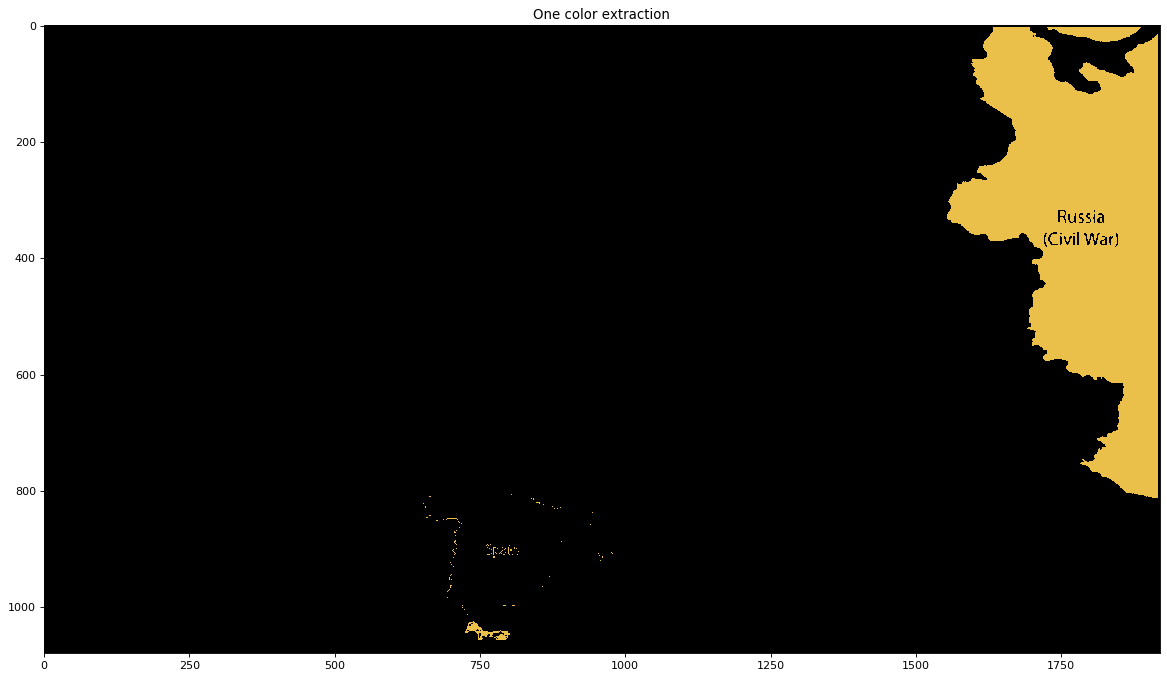

0.3286064630818688


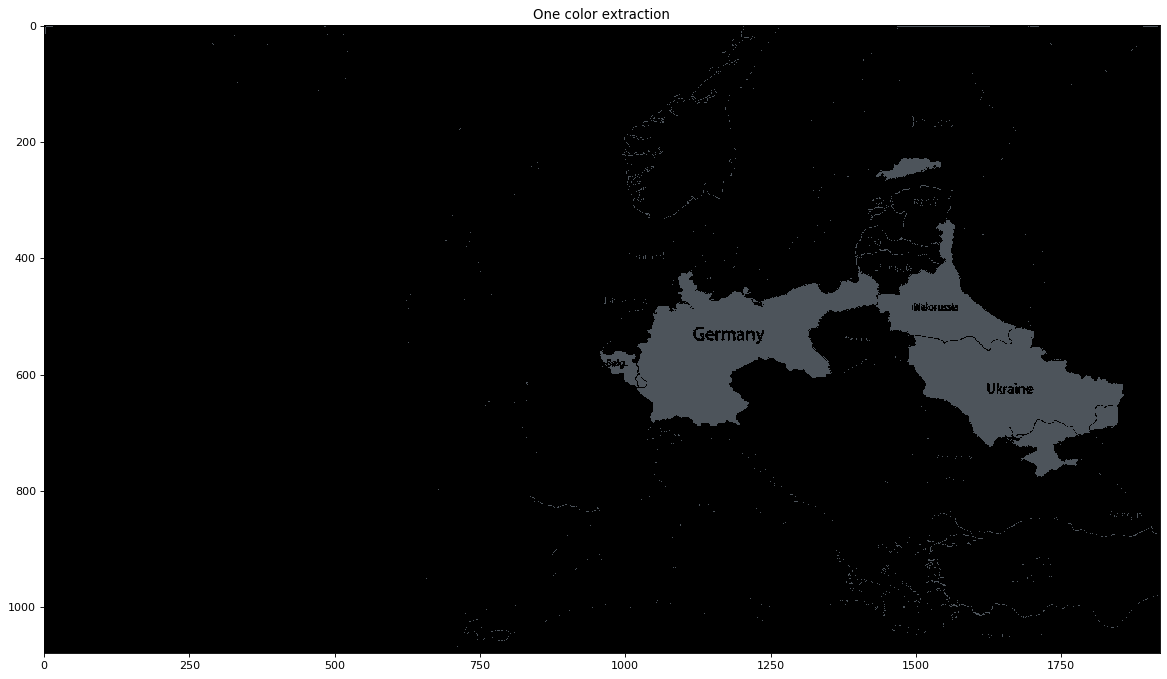

0.9641406883515181


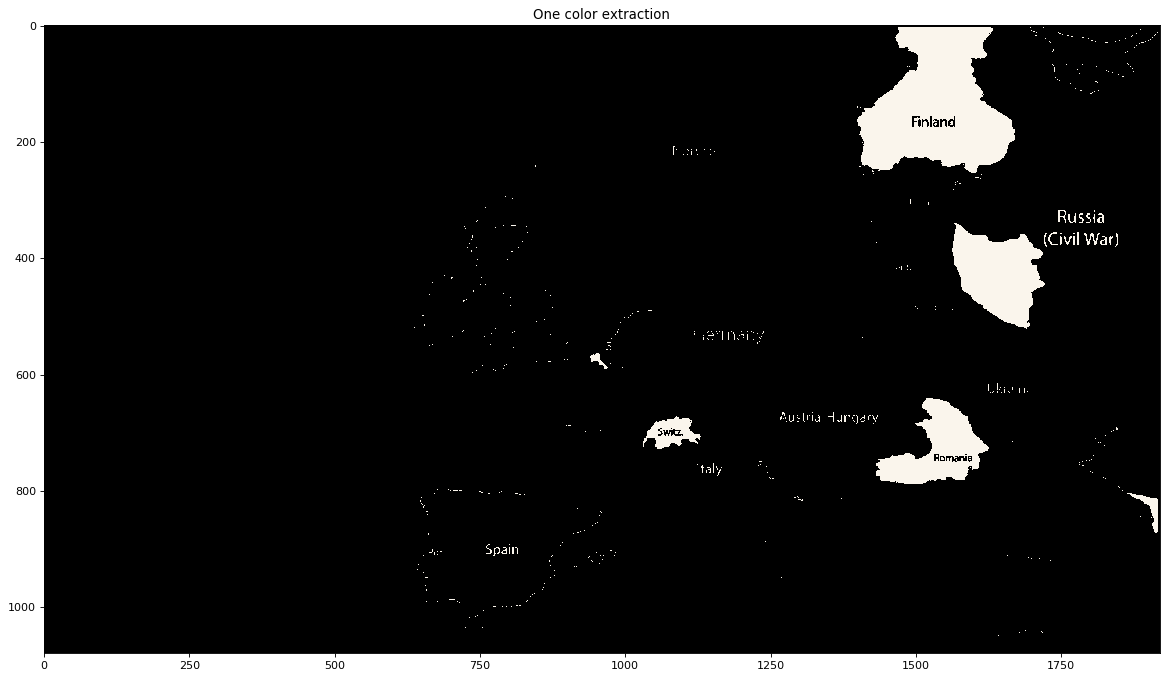

0.8811221656101912


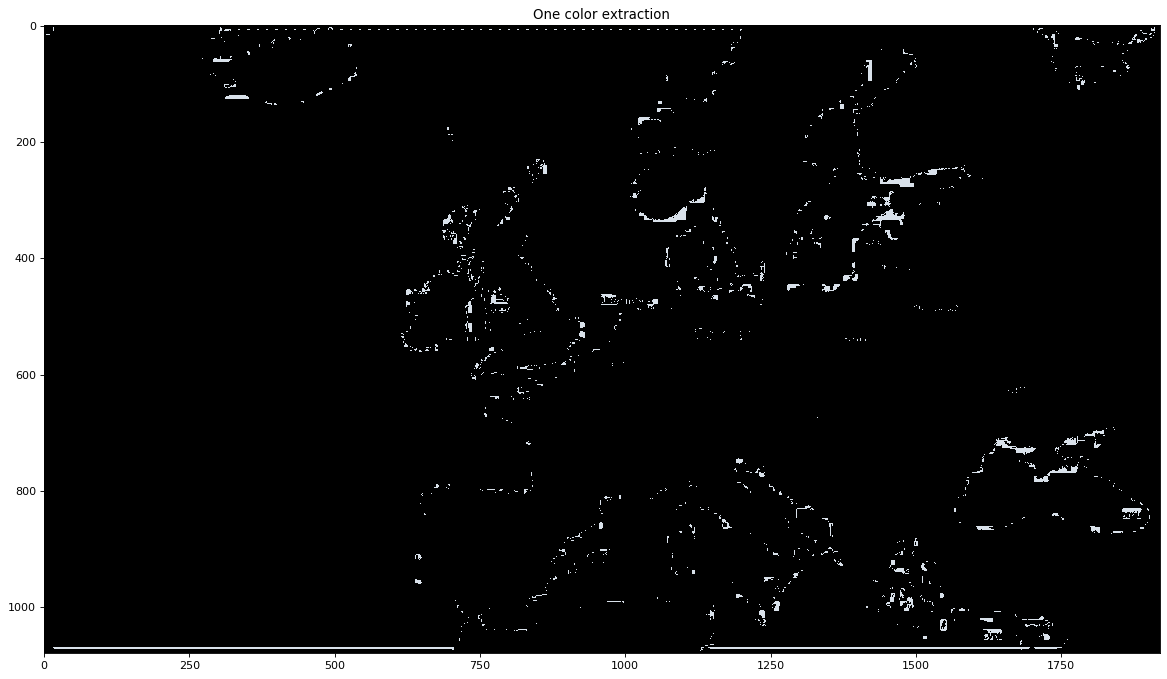

0.44573799890307836


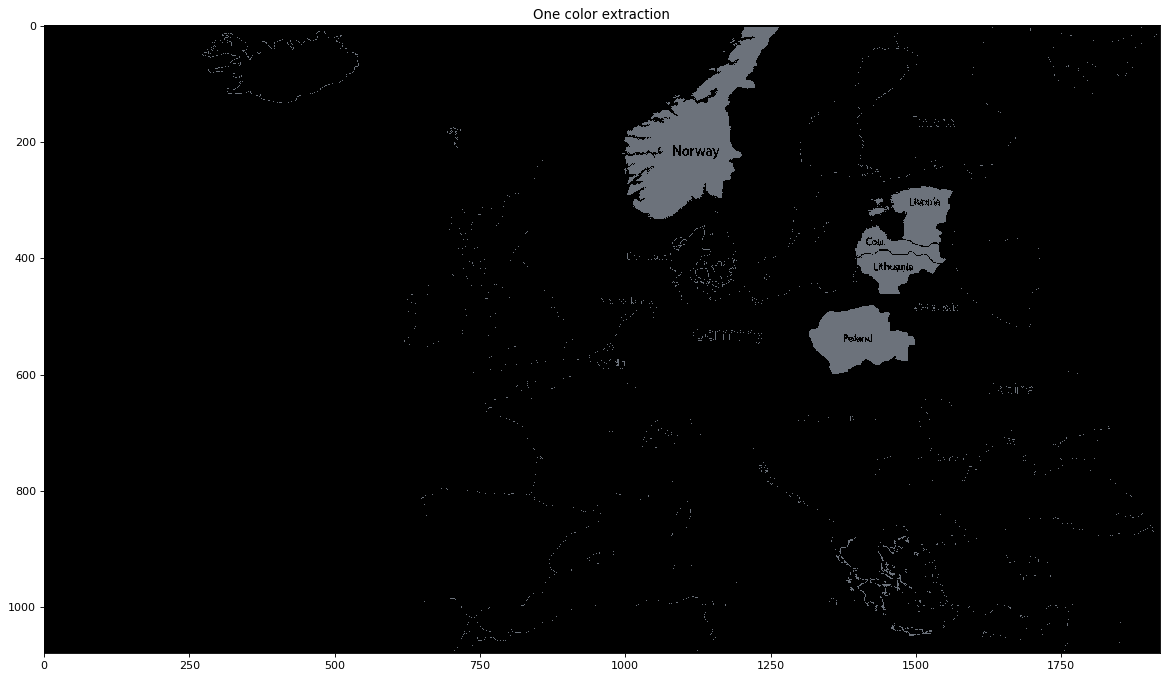

0.4395489794686909


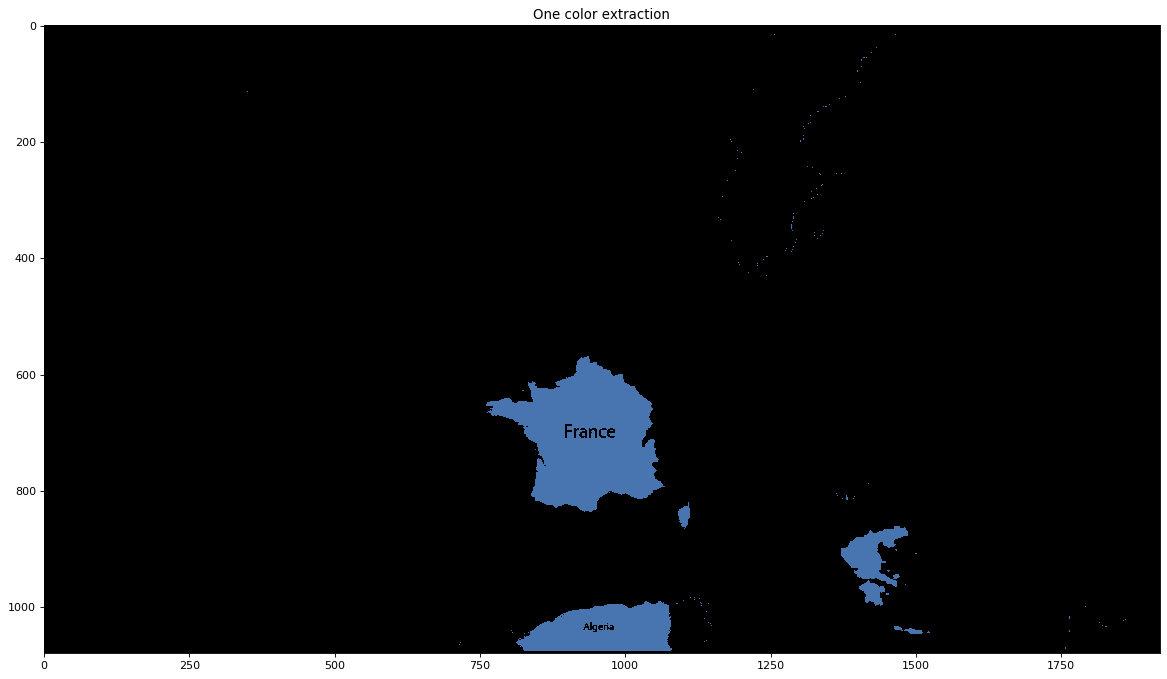

0.2502550498813737


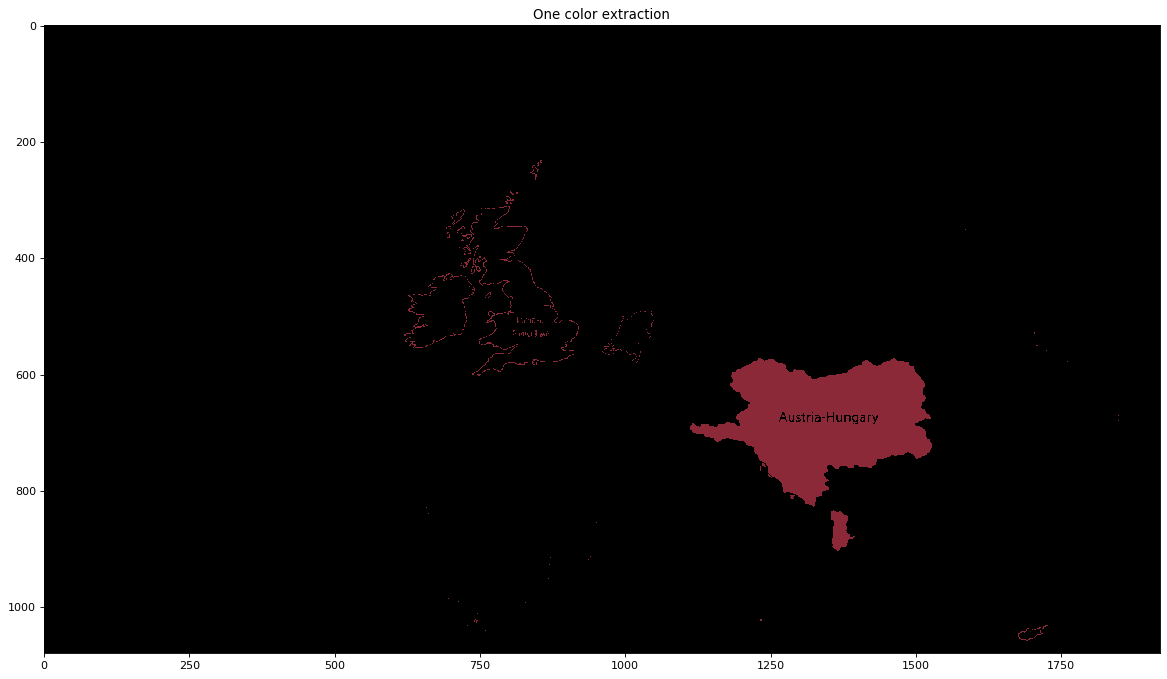

0.43339905998522227


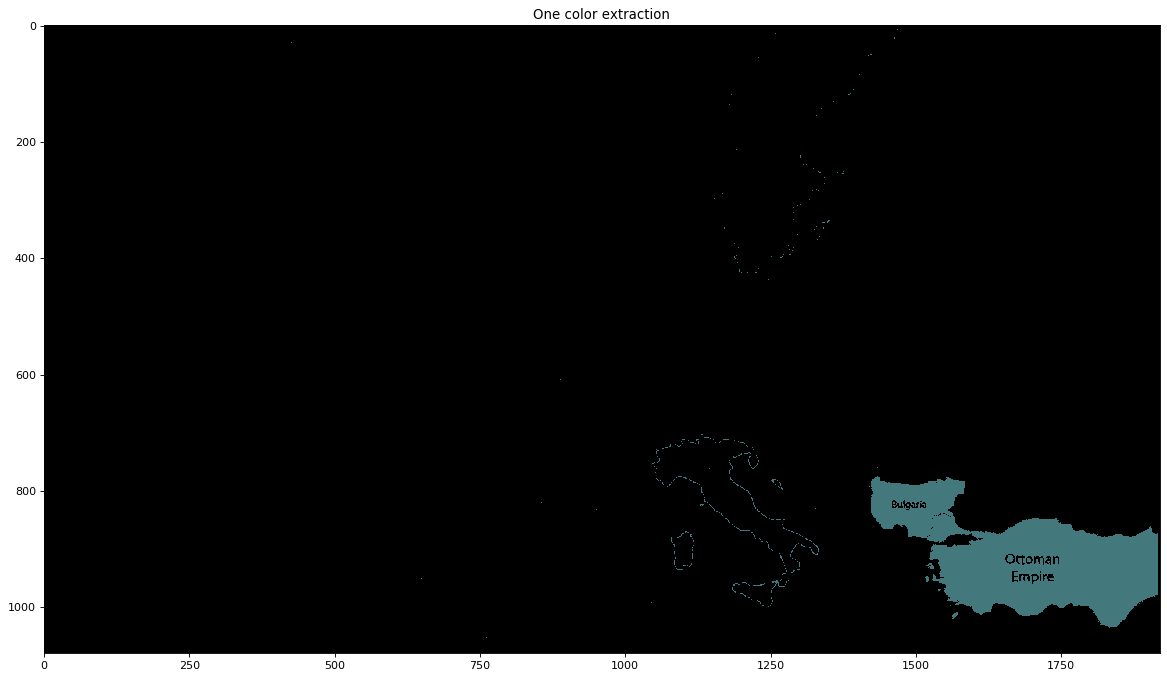

0.598747354986744


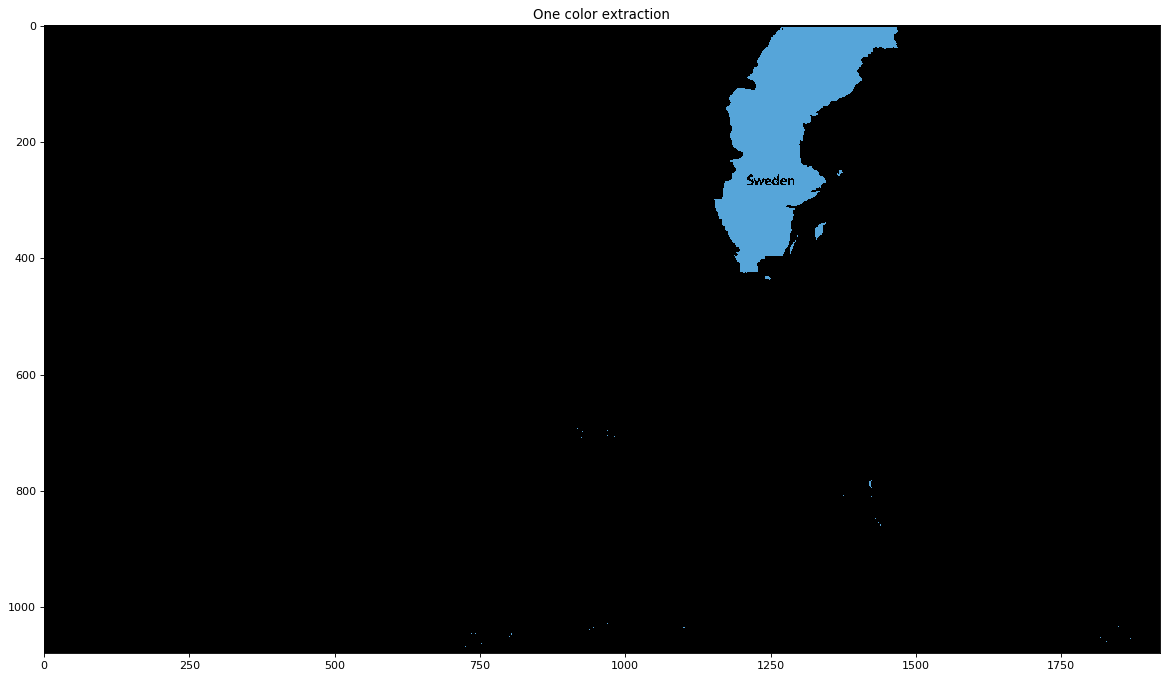

0.8833191262552383


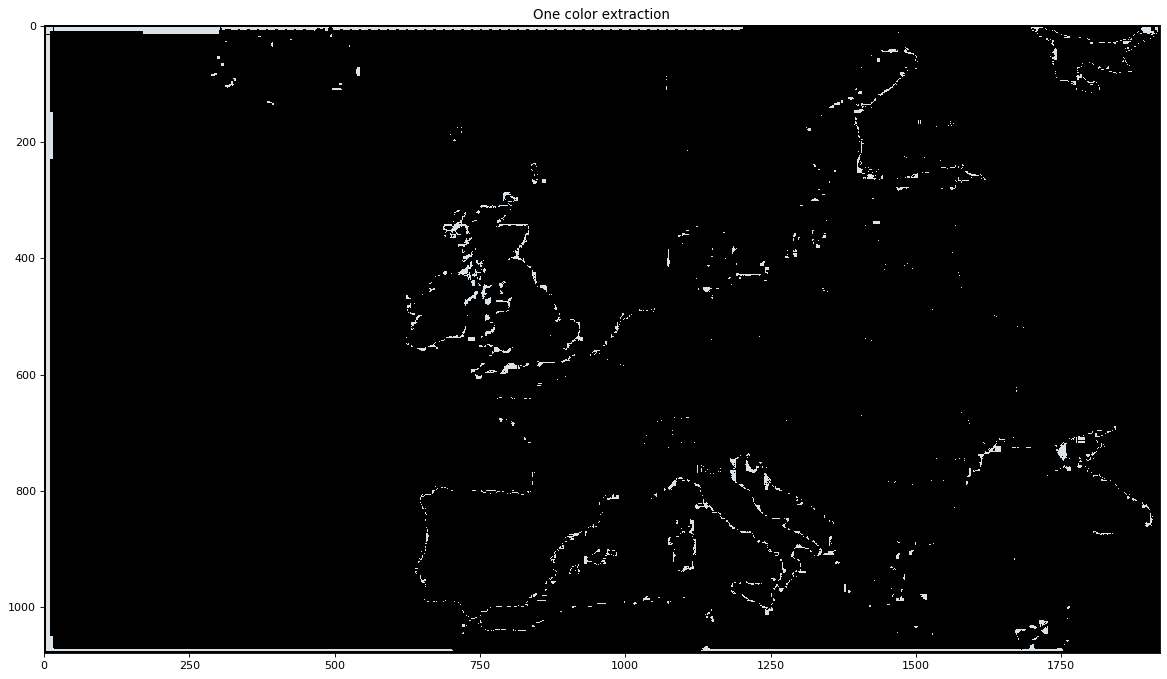

0.6695694613858407


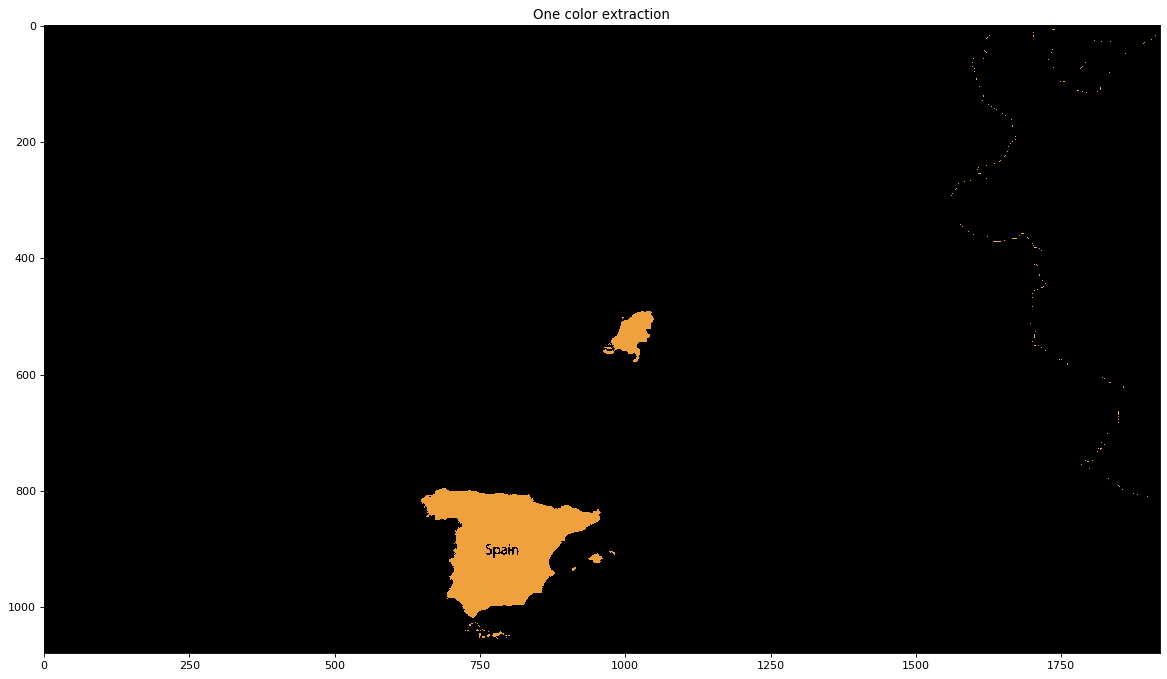

0.8838489809636073


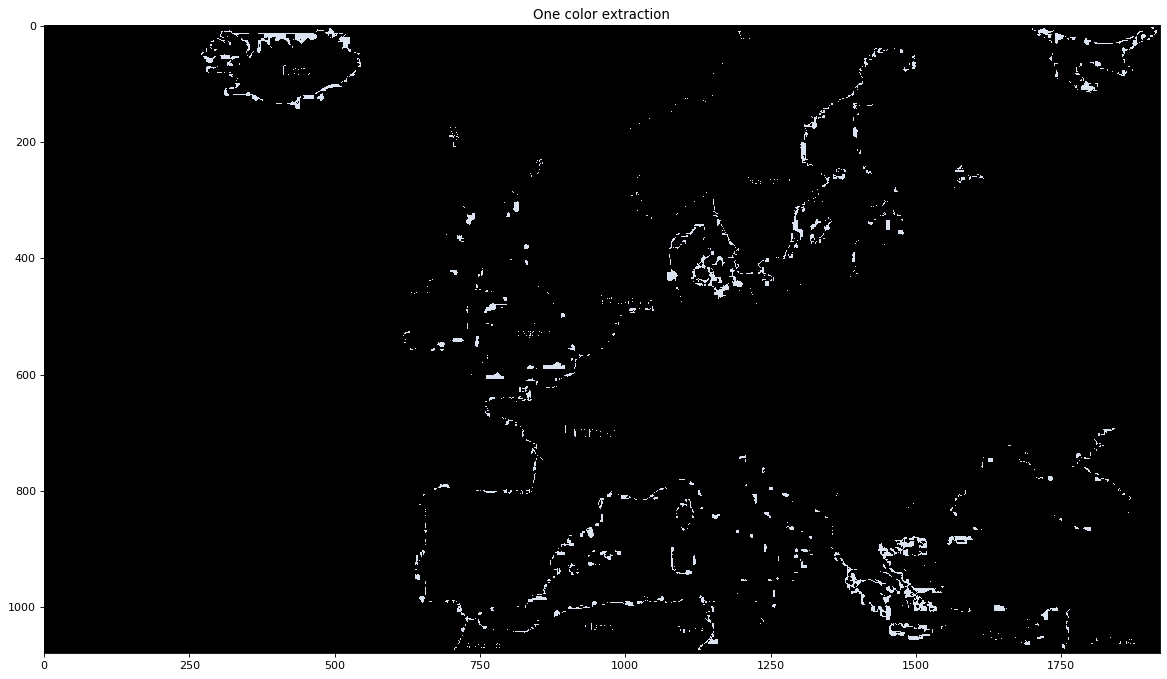

0.36578572338977094


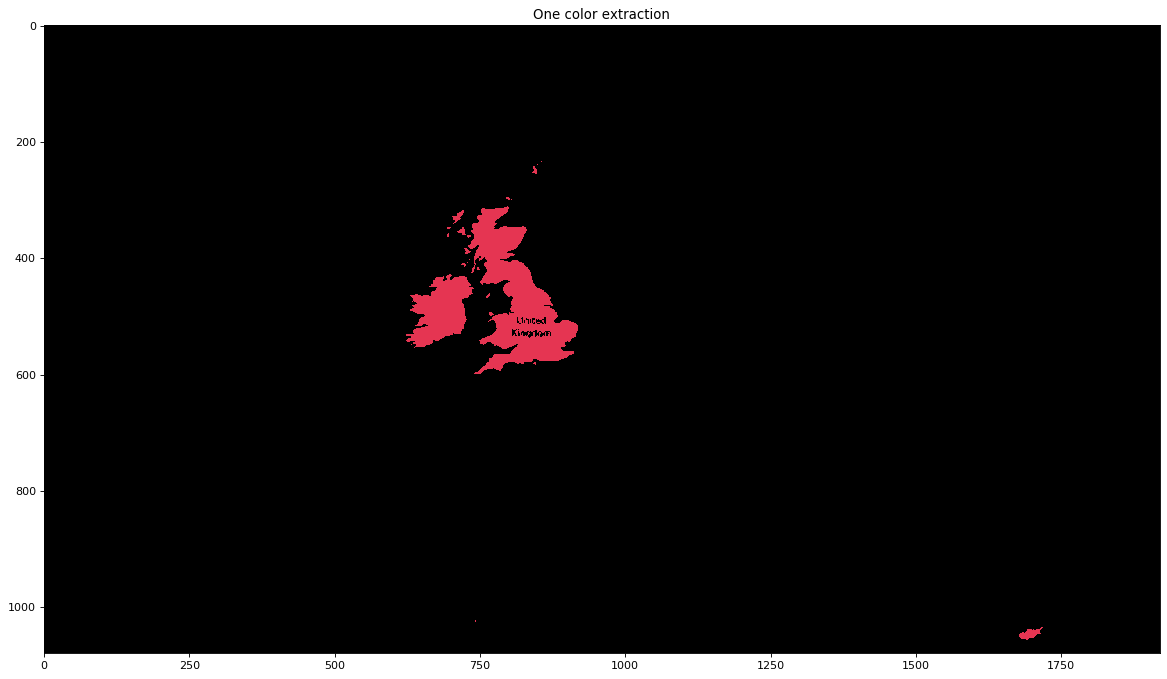

0.5250636956046063


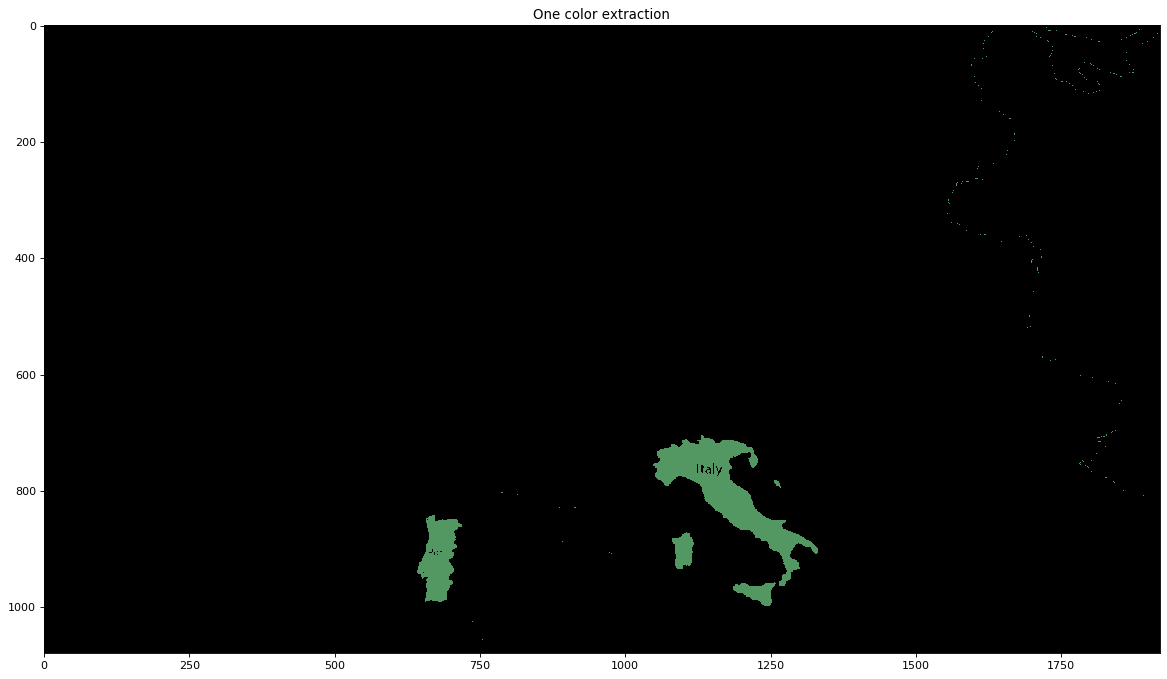

0.9118192523506736


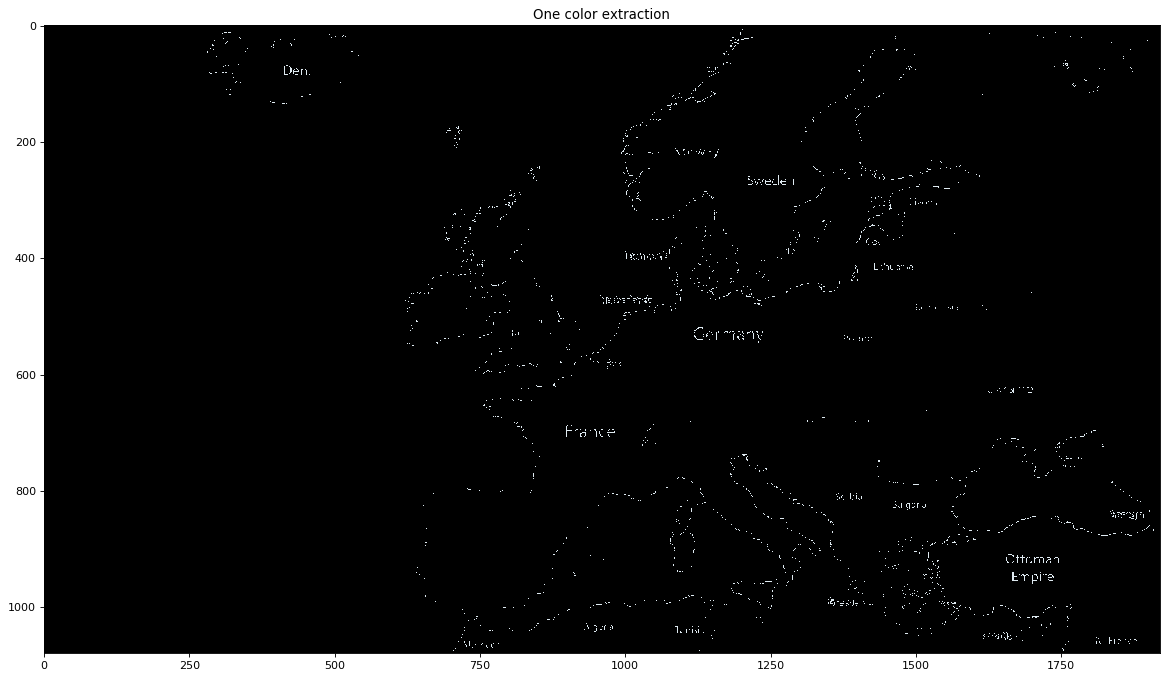

0.7316545356925065


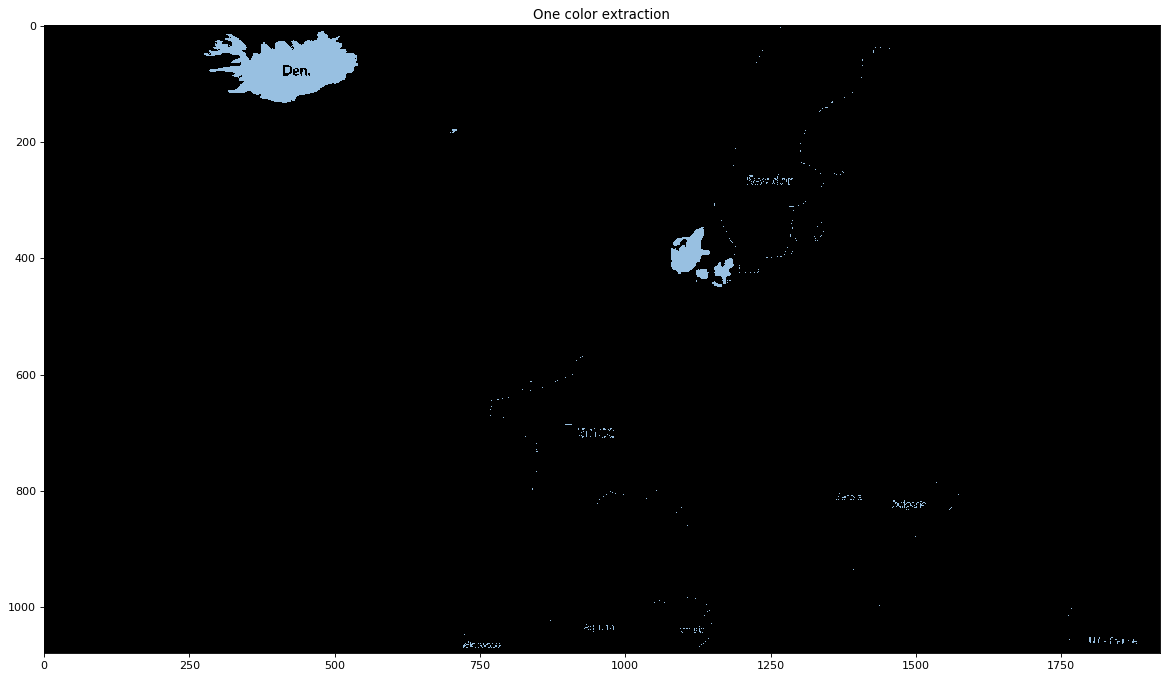

0.004300058701445445


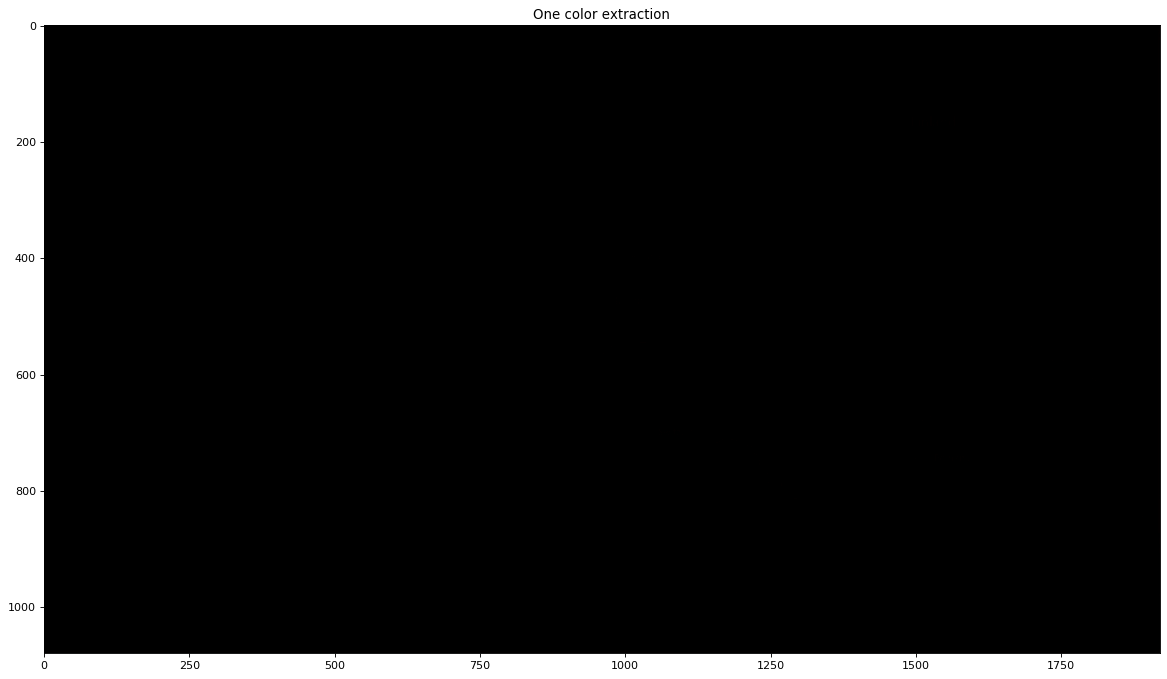

0.5597236979045978


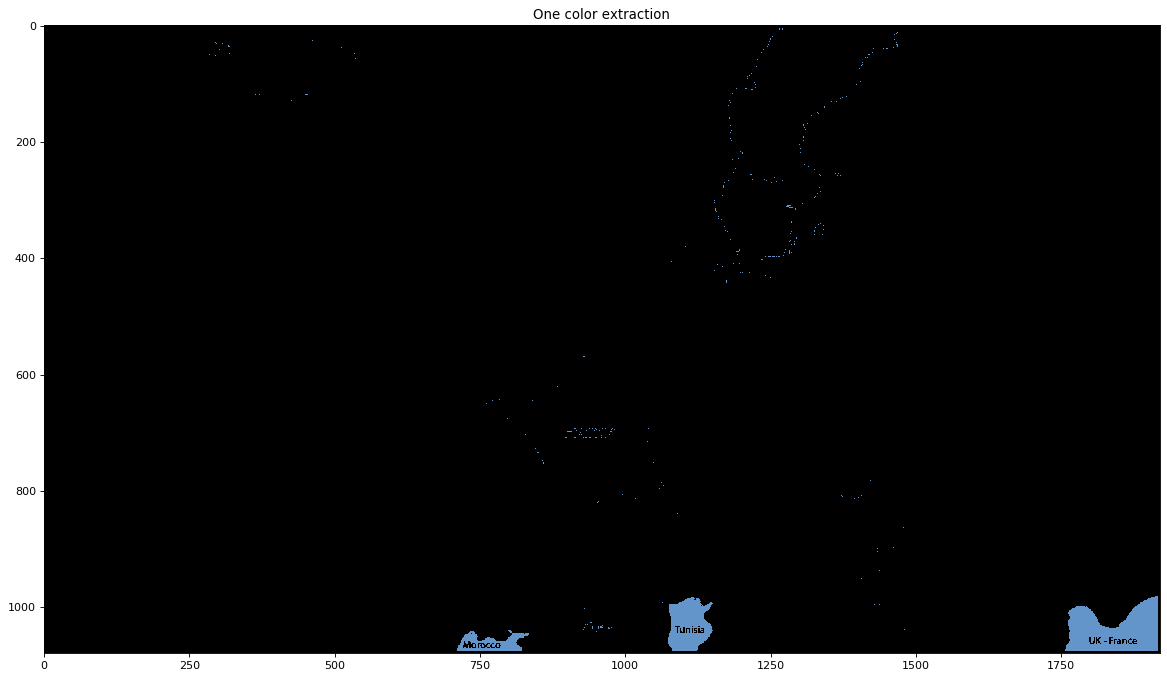

0.22853693295363284


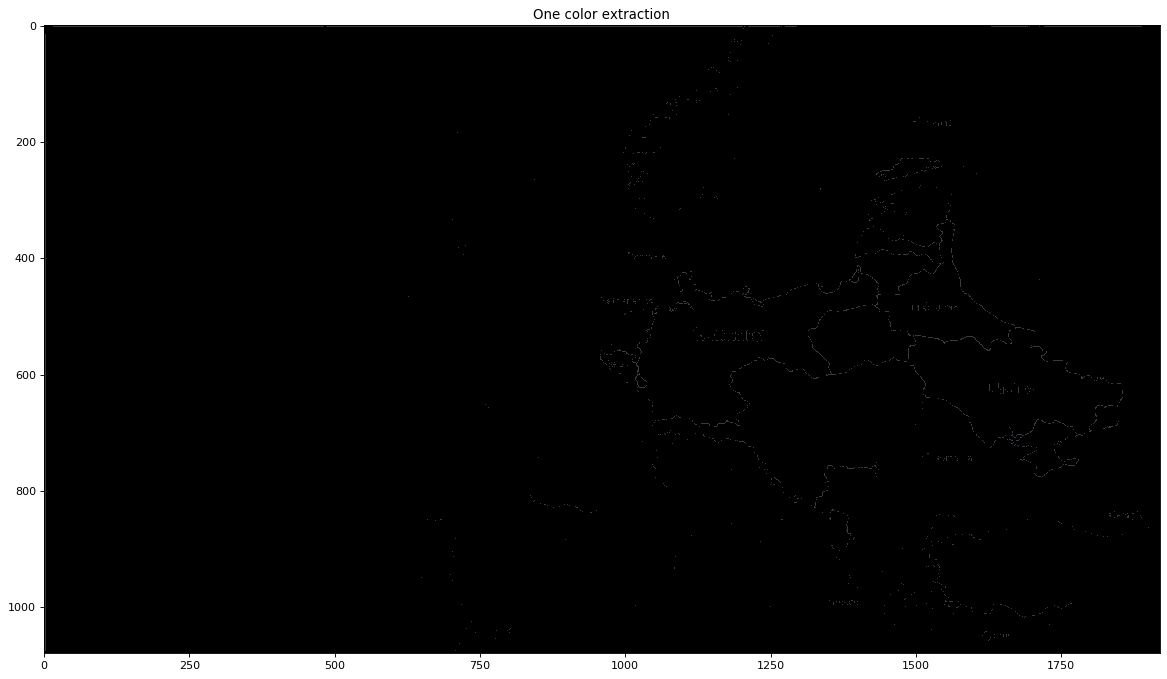

0.022409000273489847


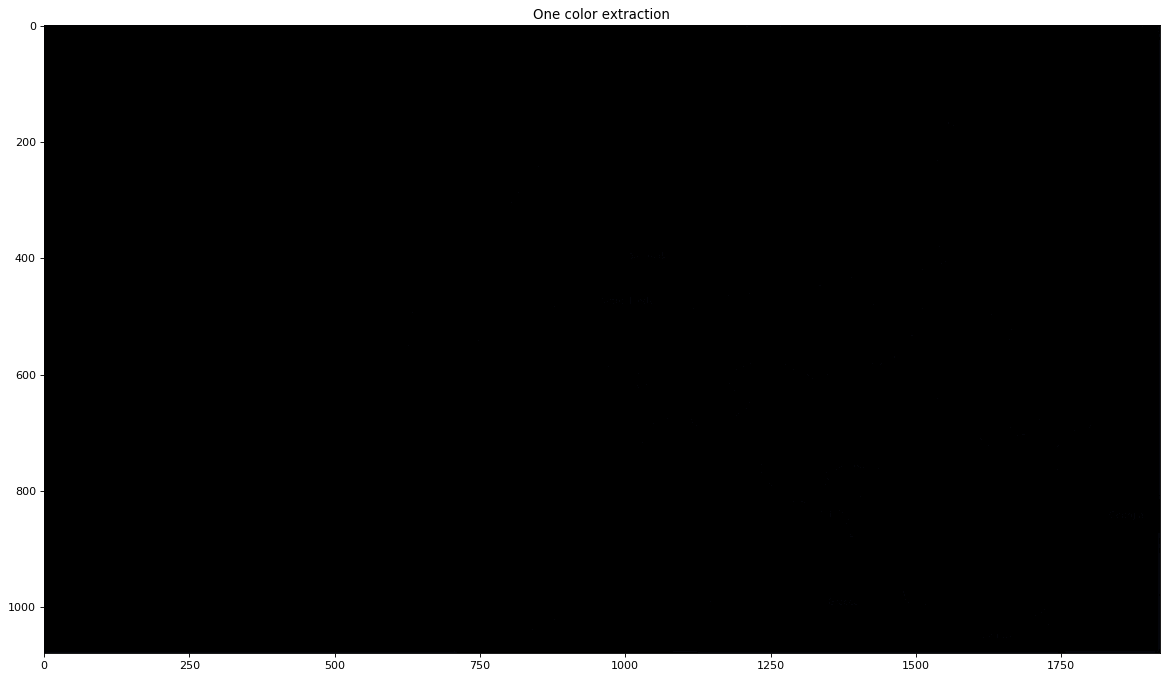

0.6595484739911793


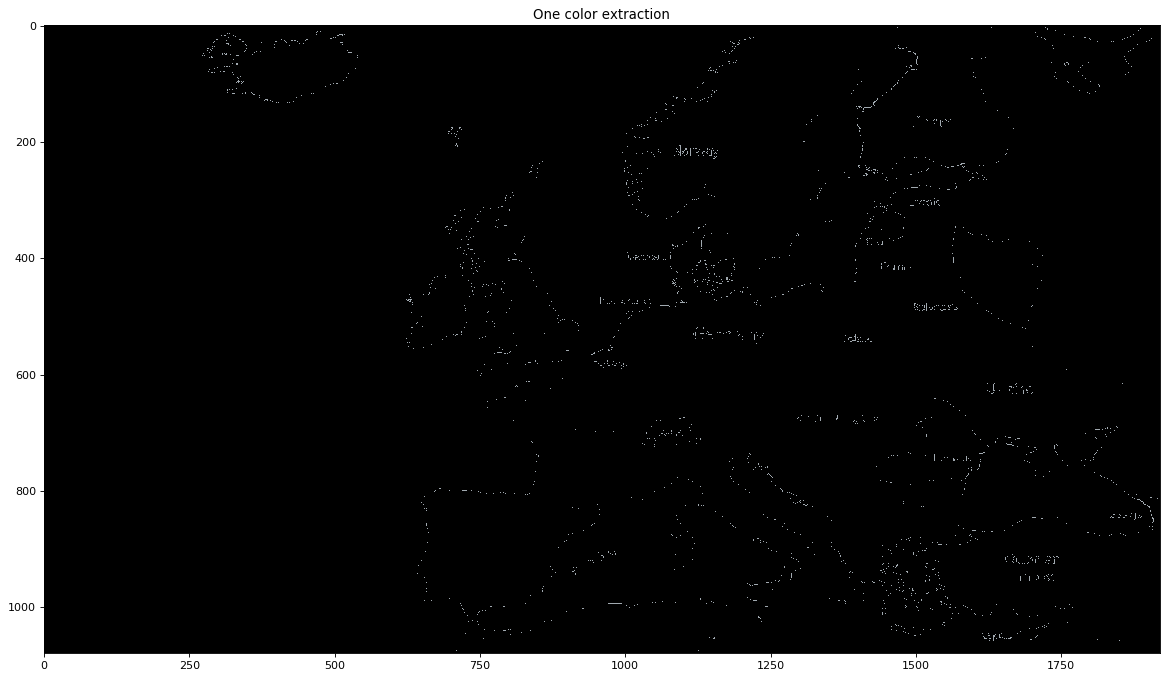

0.24385817586714564


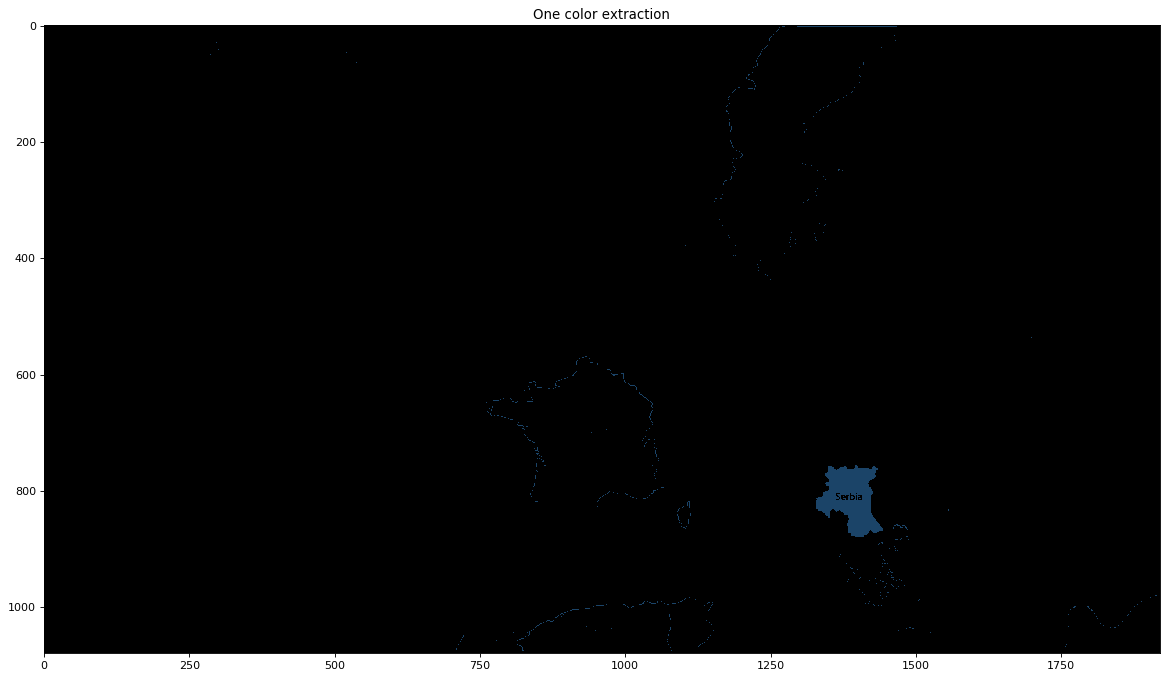

0.8271300454667998


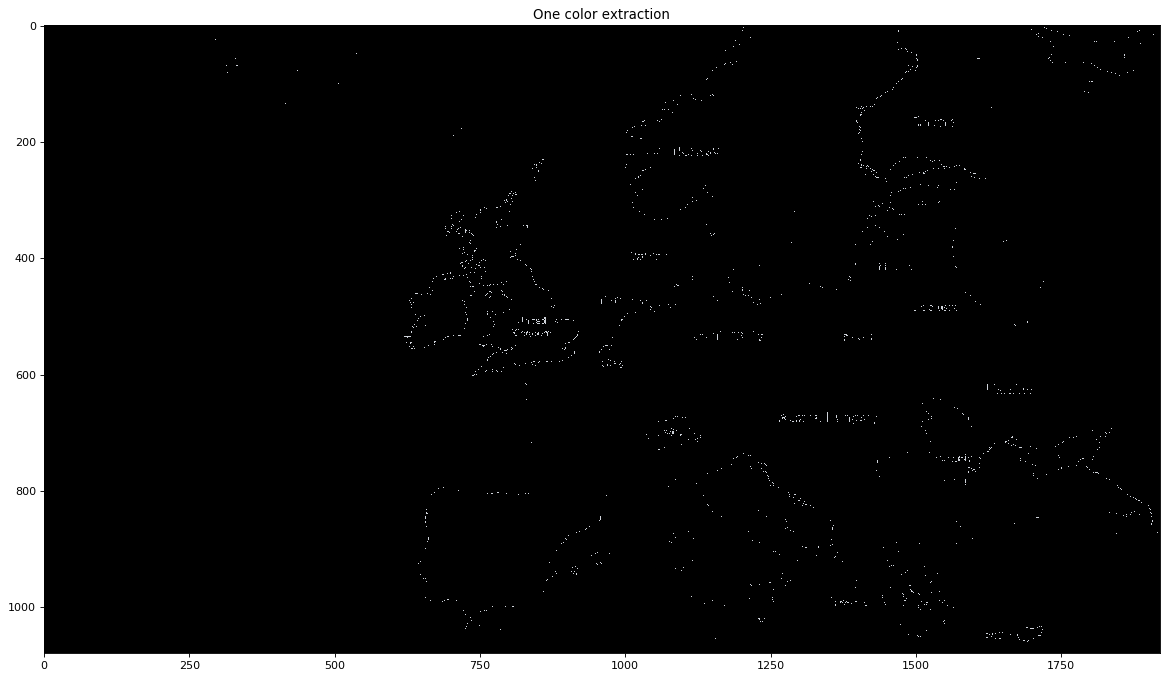

0.7865785067371667


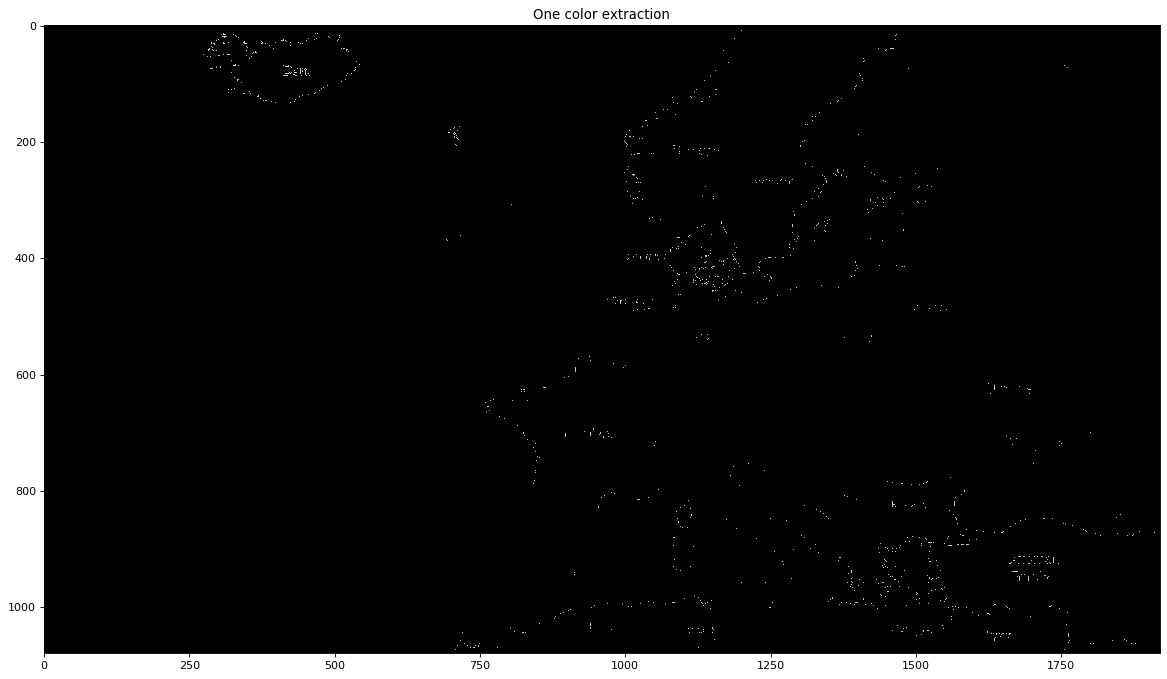

In [288]:
def get_masked(source_img, colour):
    h, w = source_img.shape[:2]
    return source_img==colour
grayscale_europe = color.rgb2gray(europe_cleaned)
grayscale_major_colors = color.rgb2gray(np.concatenate(extracted_colors['value'].values).reshape((len(extracted_colors), 1, 3))).flatten()
print(grayscale_major_colors)
#display_img(grayscale_europe, 'Europe grayscale')
#display_img(grayscale_major_colors, 'Colors in europe', True)
for col in grayscale_major_colors:
    print(col)
    masked = np.repeat(get_masked(grayscale_europe,col), 3).reshape(europe_cleaned.shape)
    display_img(np.where(masked, europe_cleaned, np.zeros(europe_cleaned.shape)), "One color extraction", True)